# EDA Notebook No. 2

In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats

from pandas import DataFrame

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score,\
recall_score, f1_score, roc_curve, precision_recall_curve, auc, plot_confusion_matrix

%matplotlib inline

**Knight Commission**
- Used both by the Delta Report and Schwartz (https://www.knightcommission.org/)
- 15 years included in the data (2005–2019)
- 353 institutions 

In [2]:
knight = pd.read_excel('data/knight_05_19.xlsx')

**Equity in Athletics Data Analysis**
- US Dept of Education Data (https://ope.ed.gov/athletics/#/)
- Broken down by sport as well as men/women/coed, but I only want high-level overview of finance data

In [3]:
eada_rev = pd.read_csv('data/EADA_Revenues.csv')

In [4]:
eada_rev = eada_rev[['Survey Year', 'UNITID', 'Institution Name', 'Classification Name', 'Grand Total Revenue']]

In [5]:
eada_rev.shape

(29491, 5)

In [6]:
eada_exp = pd.read_csv('data/EADA_Expenses.csv')

In [7]:
eada_exp = eada_exp[['Survey Year', 'UNITID', 'Institution Name', 'Classification Name', 'Grand Total Expenses']]

In [8]:
eada_part = pd.read_csv('data/EADA_Participation.csv')

In [9]:
eada_part = eada_part[['Survey Year', 'UNITID', 'Institution Name', 'Classification Name', 'Unduplicated Count Men\'s Participation', 'Unduplicated Count Women\'s Participation']]
                       

In [10]:
eada_merge_1 = pd.merge(eada_rev, eada_exp, how='inner', left_on=['Survey Year', 'UNITID', 'Institution Name', 'Classification Name'], 
                        right_on = ['Survey Year', 'UNITID', 'Institution Name', 'Classification Name'])

In [11]:
eada_merged = pd.merge(eada_merge_1, eada_part, how='inner', left_on=['Survey Year', 'UNITID', 'Institution Name', 'Classification Name'], 
                        right_on = ['Survey Year', 'UNITID', 'Institution Name', 'Classification Name'])

In [12]:
eada_merged.rename(columns={'Unduplicated Count Men\'s Participation': 'Total Male Participation', 
                            'Unduplicated Count Women\'s Participation': 'Total Female Participation'}, 
                   inplace = True)

In [13]:
eada_merged

,Survey Year,UNITID,Institution Name,Classification Name,Grand Total Revenue,Grand Total Expenses,Total Male Participation,Total Female Participation
0,2005,222178,Abilene Christian University,NCAA Division II (with football),5400385,5074419,207.0,89.0
1,2005,138558,Abraham Baldwin Agricultural College,NJCAA Division I,643297,643297,58.0,40.0
2,2005,126182,Adams State College,NCAA Division II (with football),2781663,2781663,264.0,110.0
3,2005,188429,Adelphi University,NCAA Division II (without football),4249797,3556017,145.0,105.0
4,2005,188438,Adirondack Community College,NJCAA Division III,114840,111670,62.0,30.0
...,...,...,...,...,...,...,...,...
29486,2019,181853,York College,NAIA Division II,3805596,3805596,166.0,146.0
29487,2019,217059,York College of Pennsylvania,NCAA Division III without football,2857778,2638512,259.0,221.0
29488,2019,141361,Young Harris College,NCAA Division II without football,5751311,5751311,191.0,123.0
29489,2019,206695,Youngstown State University,NCAA Division I-FCS,16292051,16292051,260.0,187.0


In [14]:
knight_eada_merged = pd.merge(eada_merged, knight, how='inner', left_on=['Survey Year', 'UNITID', 'Institution Name'], 
                        right_on = ['Year', 'IPEDS ID', 'Data'])


**NCES (National Center for Education Statistics) IPEDS (Integrated Postsecondary Education Data System)**
- Enrollment and Rention Records (https://nces.ed.gov/ipeds/)

In [15]:
ipeds_final = pd.read_excel('Data/ipeds_final.xlsx', index_col=0)

### Merging dataframes

In [16]:
df = pd.merge(knight_eada_merged, ipeds_final, how='inner',
              left_on=['Survey Year', 'UNITID', 'Institution Name'], 
              right_on = ['year', 'unitid', 'institution name'])

Seems like there is a mismatch with the number of schools included in the Knight Commission data vs. the other data sets. My plan is to drop all of the rows that have missing values from the Knight Commission data to get the number of data points in the set more even.

In [17]:
df = df[df['Total Expenses'].notna()]

In [18]:
len(df['Institution Name'].unique())

166

In [19]:
# Result is 168 institutions with 47 features
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2416 entries, 0 to 2489
Data columns (total 48 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Survey Year                                                            2416 non-null   int64  
 1   UNITID                                                                 2416 non-null   int64  
 2   Institution Name                                                       2416 non-null   object 
 3   Classification Name                                                    2416 non-null   object 
 4   Grand Total Revenue                                                    2416 non-null   int64  
 5   Grand Total Expenses                                                   2416 non-null   int64  
 6   Total Male Participation                                               2416 non-null   f

### Cleaning data

In [20]:
# Removing columns used in merges.
# Removing "Classification Name" because I have the same data from Knight Commission
# Removing "Total Expenses" and "Total Revenues" to be consistent with Schwartz's analysis
df = df.drop(columns=['Data', 'IPEDS ID', 'Year', 'unitid', 'institution name', 'year', 'Classification Name',
                      'Total Expenses', 'Total Revenues'])

I realized that there are two columns named "Competition Guarantees", so I will rename those columns for ease of interpretation.

In [21]:
df.rename(columns={'Competition Guarantees': 'Competition Guarantees (Expenses)', 
                  'Competition Guarantees.1': 'Competition Guarantees (Revenues)'},
         inplace=True)

"FBS Conference" has missing values, but this is because not every school in this list is in the FBS. Filling in missing values with 'N/A'.

In [22]:
df['FBS Conference'].fillna(value='N/A',inplace=True)

There are a number of columns with only a handful of missing values. Given that I do not know why these values are missing, I think the most reasonable solution for filling in these values is to replace them with the median value for the columns. Here is a list of columns that will undergo this cleaning step:
- "Medical" has 5 missing values.
- "Competition Guarantees (Expenses)" has 7 missing values.
- "Competition Guarantees (Revenues)" has 6 missing values.
- "Recruiting" has 6 missing values.
- "Athletic Student Aid" has 5 missing values.
- "Corporate Sponsorship, Advertising, Licensing" has 9 missing values.
- "Ticket Sales" has 5 missing values.
- "Student Fees" has 33 missing values.

In [23]:
df['Medical'].fillna(df['Medical'].median(),inplace=True)
df['Competition Guarantees (Expenses)'].fillna(df['Competition Guarantees (Expenses)'].median(), inplace=True)
df['Competition Guarantees (Revenues)'].fillna(df['Competition Guarantees (Revenues)'].median(), inplace=True)
df['Recruiting'].fillna(df['Recruiting'].median(),inplace=True)
df['Athletic Student Aid'].fillna(df['Athletic Student Aid'].median(), inplace=True)
df['Corporate Sponsorship, Advertising, Licensing'].fillna(df['Corporate Sponsorship, Advertising, Licensing'].median(), inplace=True)
df['Ticket Sales'].fillna(df['Ticket Sales'].median(), inplace=True)
df['Student Fees'].fillna(df['Student Fees'].median(), inplace=True)

There are 43 schools in this list that are in the "No Football Subdivision" of the NCAA. This means that they do not have any football spending or coaching salaries, so I think it makes sense to fill in these rows with 0.0.

In [24]:
df['Total Football Spending'].fillna(value=0.0,inplace=True)
df['Total Football Coaching Salaries'].fillna(value=0.0,inplace=True)

There are still some missing values in the "Part-Time Retention Rate" column. Given that retention rates are the focus of this study, I will drop rows with missing values. This only drops two institutions from the dataset, so I think this is worth the loss of data.

In [25]:
df = df[df['Part-time Retention Rate'].notna()]

With a couple hundred missing values in "Athletics Related Debt" and "Annual Debt Service, Leases and Rental Fees on Athletic Facilities," I did not feel comfortable filling in missing values. If I drop rows from these two debt related features, I still have 166 institutions in my data frame.

In [26]:
df = df[df['Athletics Related Debt'].notna()]
df = df[df['Annual Debt Service, Leases and Rental Fees on Athletic Facilities'].notna()]
len(df['Institution Name'].unique())

166

In [27]:
# No more missing values
df.isna().sum().sum()

0

# Feature Engineering

In [28]:
# Creating new variable for the amount of academic spending per non student athlete
df['Academic Spending per FTE Student'] = round(df['Total Academic Spending (University-Wide)']/df['Full-time Enrollment'], 2)

In [29]:
# Creating total number of student athletes per institution
df['Total Student Athletes'] = df['Total Male Participation'] + df['Total Female Participation']
df.drop(columns=['Total Male Participation', 'Total Female Participation'], inplace=True)

In [30]:
# Creating new variable for the amount of athletic spending per student athlete
df['Athletic Spending per Student Athlete'] = round(df['Grand Total Expenses']/df['Total Student Athletes'],2)

In [31]:
# Creating new varibale to represent the ratio of how much a university spends per student athlete
# compared with how much they spend per FTE student
df['Ratio of Athletic Spending vs. Academic Spending'] = df['Athletic Spending per Student Athlete']/df['Academic Spending per FTE Student']

In [32]:
# Creating a new variable to capture the weighted average retention rate. This will be the target variable.
# First, creating new variables for the number of retained full-time and part-time students.
df['No. Full-Time Students Retained'] = round(df['Full-time Enrollment']*(df['Full-time Retention Rate']/100))
df['No. Part-Time Students Retained'] = round(df['Part-time Enrollment']*(df['Part-time Retention Rate']/100))

In [33]:
# Now creating the weighted retention ratio by adding the number of retained full-time and part-time students
# and dividing by the total enrollment size
df['Weighted Retention Rate'] = round(((df['No. Full-Time Students Retained'] + df['No. Part-Time Students Retained'])/df['Total Enrollment'])*100, 2)
# df.drop(columns=['Full-time Retention Rate', 'Part-time Retention Rate', 'No. Full-Time Students Retained', 'No. Part-Time Students Retained'], inplace=True)

# EDA

In [34]:
print("No. of rows in df:         ",df.shape[0])
print("No. of features in df:     ",df.shape[1])
print(f"Years contained in df:      {df['Survey Year'].min()}–{df['Survey Year'].max()}")
print("No. of Unique Institutions:",len(df['Institution Name'].unique()))

No. of rows in df:          2079
No. of features in df:      44
Years contained in df:      2005–2019
No. of Unique Institutions: 166


In [35]:
# Sorting the df year (chronologically) and school name (alphabetically) for ease of reading
df.sort_values(by=["Institution Name", "Survey Year"], inplace=True)

In [36]:
# Looking into correlations
top_10_corr = [i for i in df.corrwith(df['Weighted Retention Rate']).sort_values(ascending=False).head(10).keys()]

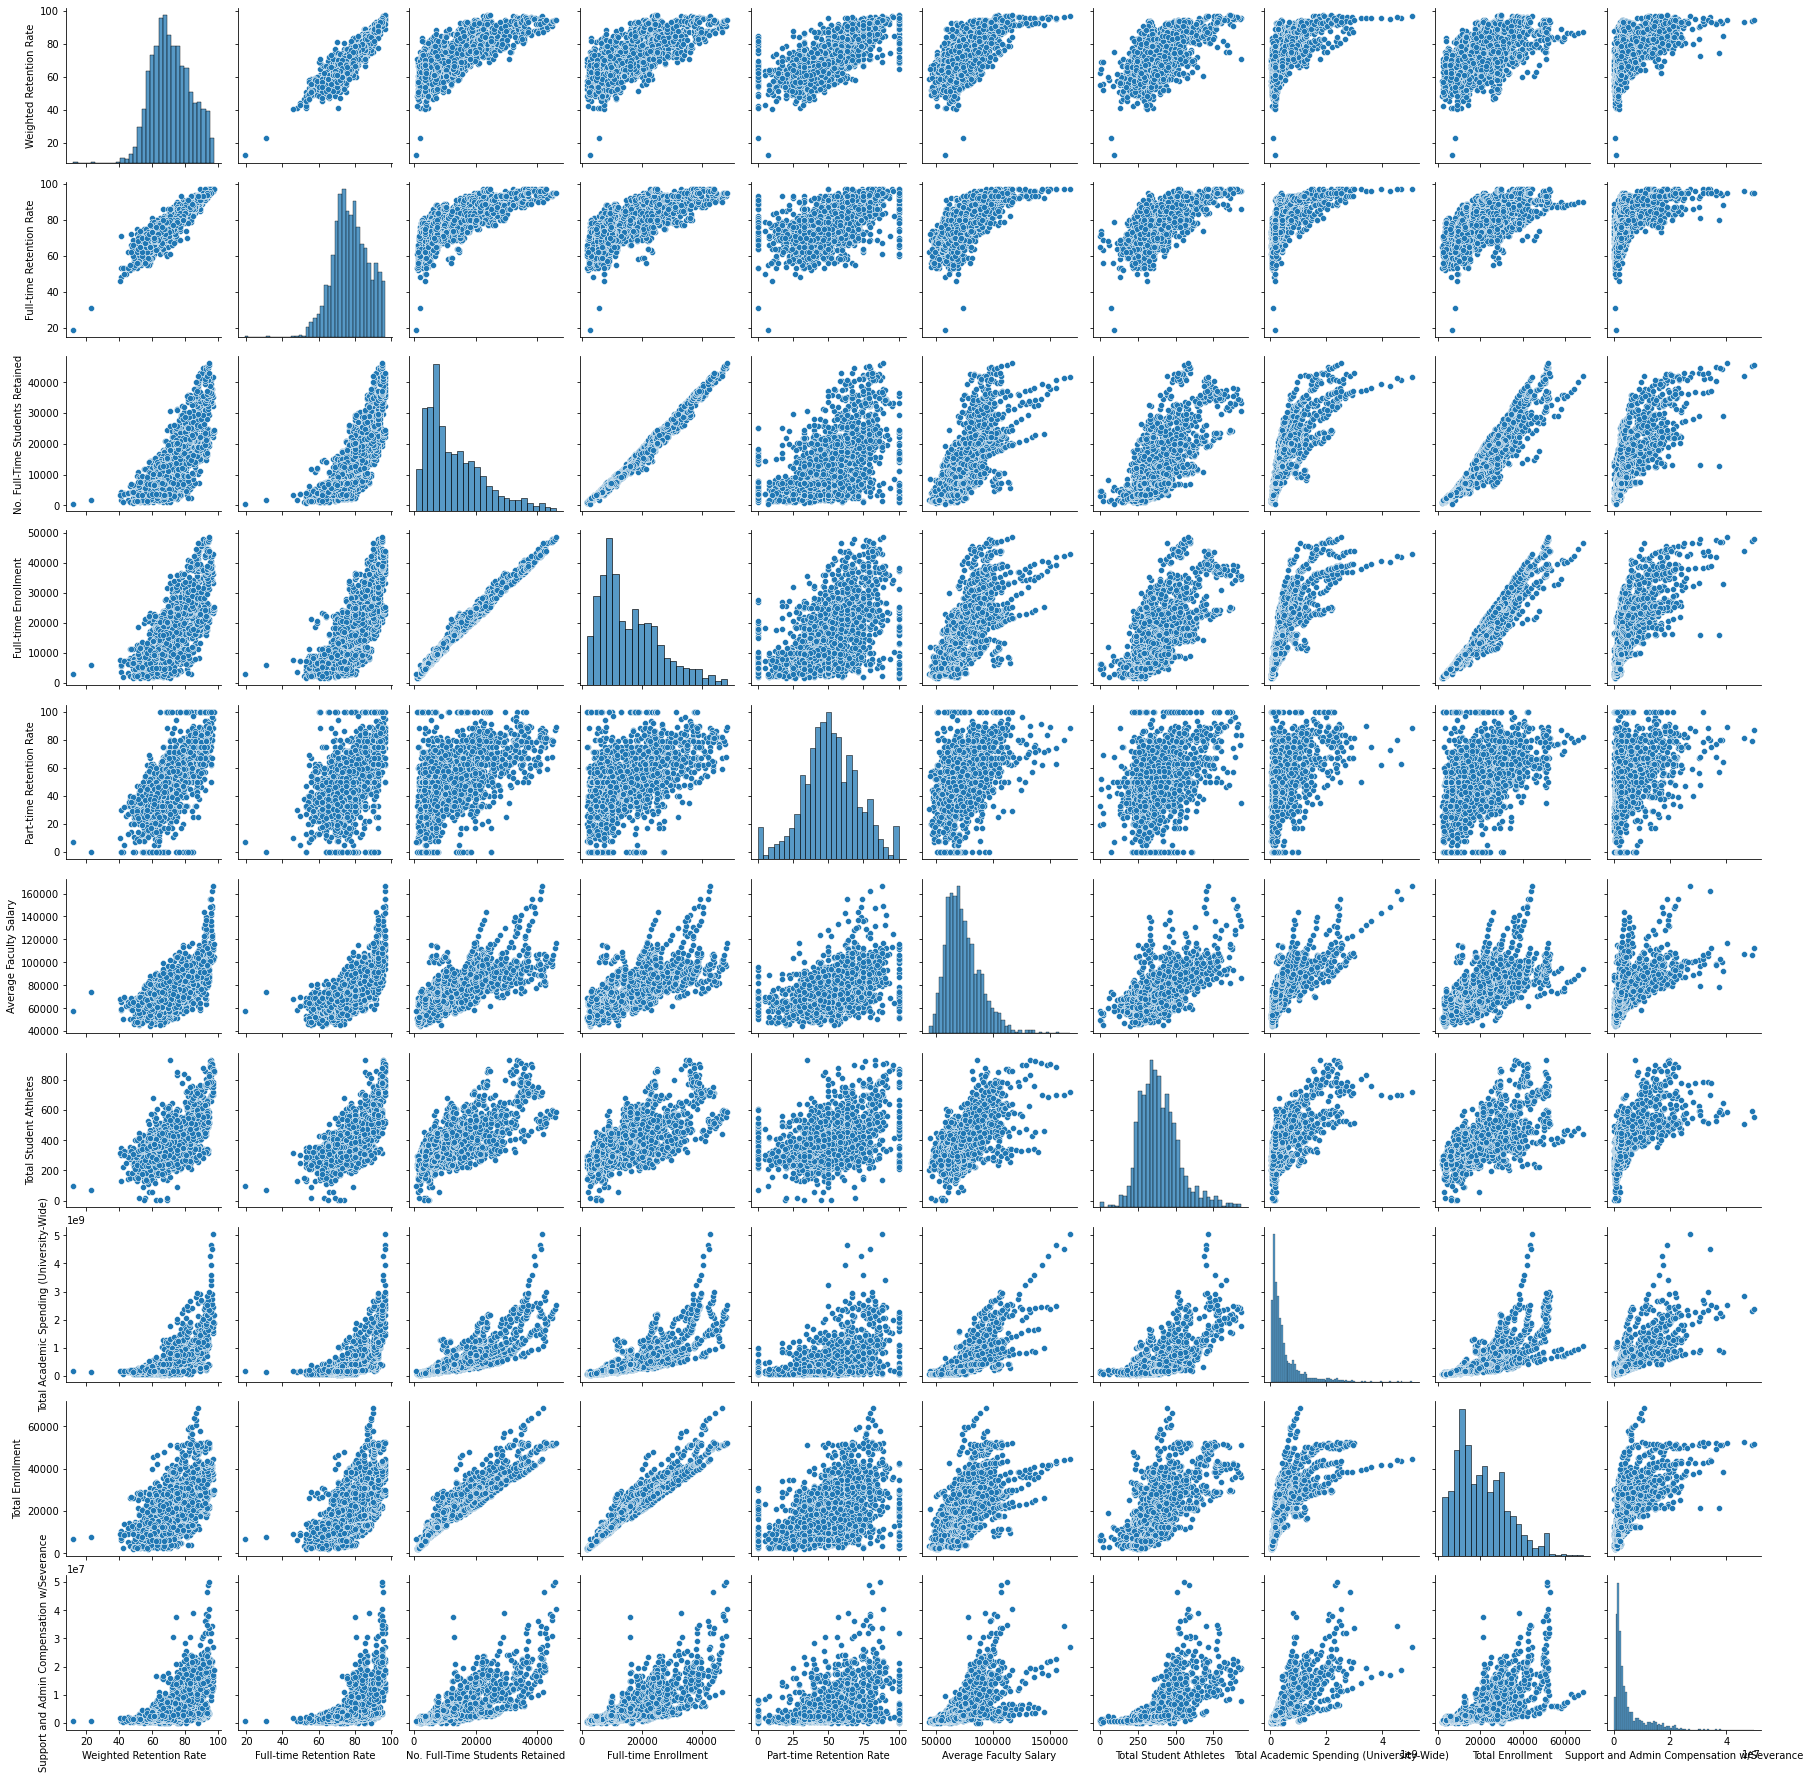

In [37]:
sns.pairplot(df,
             x_vars=top_10_corr,
             y_vars=top_10_corr
);

## Analyzing Trends

In [38]:
# Creating a new copy of the original df
df_time = df

In [39]:
# Converting "survey year" to date time
df_time['Survey Year'] = pd.to_datetime(df_time['Survey Year'], format='%Y')

In [40]:
# Setting new date time object as the index
df_time = df_time.set_index('Survey Year')

In [41]:
# Using group by to create medians for evey column in df
trends = df_time.groupby('Survey Year').median()

2.8700000000000045


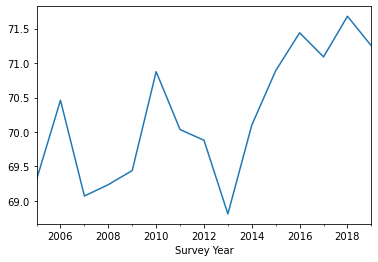

In [42]:
# Looking at weighted retention rate (target).
# Relatively consistent over the years (only ~2.87% increase)
print(trends['Weighted Retention Rate'].max() - trends['Weighted Retention Rate'].min())
trends['Weighted Retention Rate'].plot();

9060.055


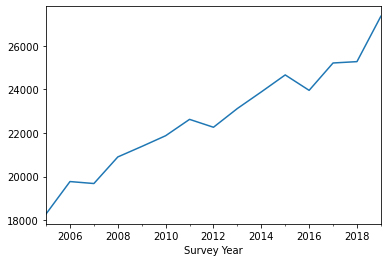

In [43]:
# Looking at academic spending per student
# Median increase about $9060 over 15 years
print(trends['Academic Spending per FTE Student'].max() - trends['Academic Spending per FTE Student'].min())
trends['Academic Spending per FTE Student'].plot();

33536.31


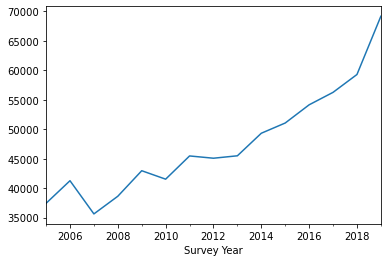

In [44]:
# Looking at athletic spending per athlete
# Median increase about $33,536 over 15 years
print(trends['Athletic Spending per Student Athlete'].max() - trends['Athletic Spending per Student Athlete'].min())
trends['Athletic Spending per Student Athlete'].plot();

175372124.0


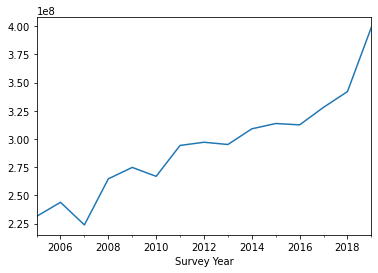

In [45]:
# Looking at total academic spending
# Median increase about $175,372,124 over 15 years
print(trends['Total Academic Spending (University-Wide)'].max() - trends['Total Academic Spending (University-Wide)'].min())
trends['Total Academic Spending (University-Wide)'].plot();

15786010.0


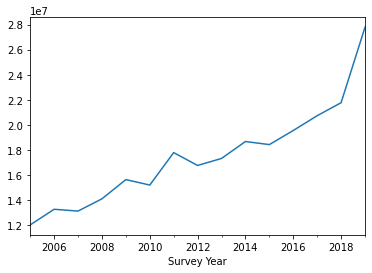

In [46]:
# Looking at total athletic spending
# Median increase about $15,786,010 over 15 years
print(trends['Grand Total Expenses'].max() - trends['Grand Total Expenses'].min())
trends['Grand Total Expenses'].plot();

16475395.0


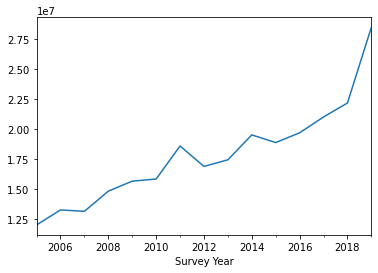

In [47]:
# Looking at total athletic revenues
# Median increase about $16,475,395 over 15 years
print(trends['Grand Total Revenue'].max() - trends['Grand Total Revenue'].min())
trends['Grand Total Revenue'].plot();

6449374.0


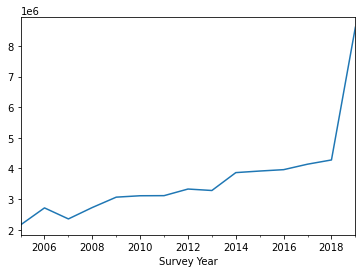

In [48]:
# Looking at total football spending
# Median increase about $6,449,374 over 15 years
print(trends['Total Football Spending'].max() - trends['Total Football Spending'].min())
trends['Total Football Spending'].plot();

1528877.0


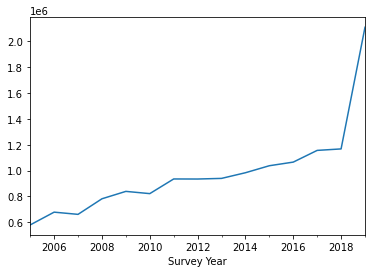

In [49]:
# Looking at total football coach salaries
# Median increase about $1,528,877 over 15 years
print(trends['Total Football Coaching Salaries'].max() - trends['Total Football Coaching Salaries'].min())
trends['Total Football Coaching Salaries'].plot();

1617863.0


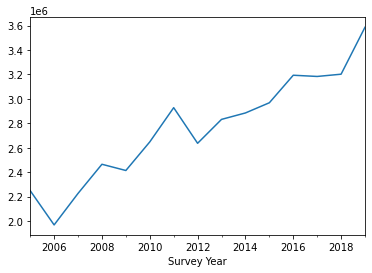

In [50]:
# Looking at student fees
# Median increase about $1,617,863 over 15 years
print(trends['Student Fees'].max() - trends['Student Fees'].min())
trends['Student Fees'].plot();

0.6169786723409829


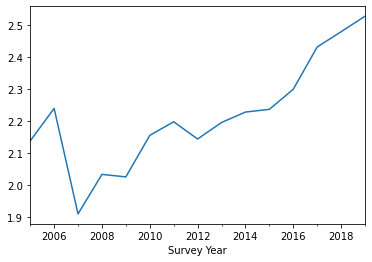

In [51]:
# Looking at ratio of athletic vs academic spending
# Median increase about 61% over 15 years
print(trends['Ratio of Athletic Spending vs. Academic Spending'].max() - trends['Ratio of Athletic Spending vs. Academic Spending'].min())
trends['Ratio of Athletic Spending vs. Academic Spending'].plot();

3.0


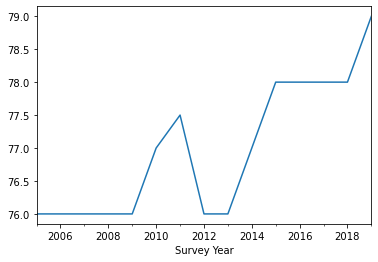

In [52]:
# Looking at full-time retention rates
# Median increase about 3% over 15 years
print(trends['Full-time Retention Rate'].max() - trends['Full-time Retention Rate'].min())
trends['Full-time Retention Rate'].plot();

4.0


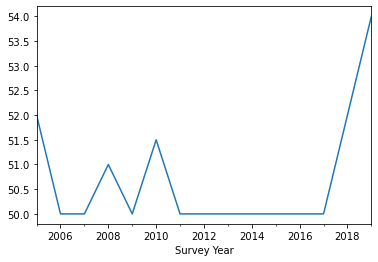

In [53]:
# Looking at part-time retention rates
# Median increase about 4% over 15 years
print(trends['Part-time Retention Rate'].max() - trends['Part-time Retention Rate'].min())
trends['Part-time Retention Rate'].plot();

4453084.0


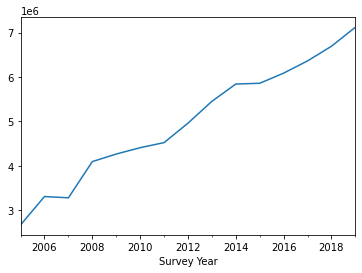

In [54]:
# Looking at institutional/goverment support
# Increase less significant than academic/athletic spending metrics ($4,453,084)
print(trends['Institutional/Government Support'].max() - trends['Institutional/Government Support'].min())
trends['Institutional/Government Support'].plot();

20498.0


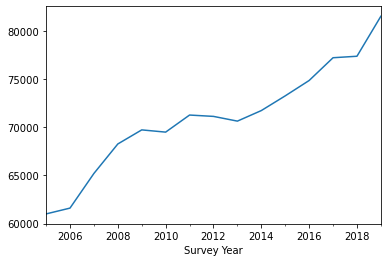

In [55]:
# Looking at average faculty salaries
# Increase less significant than athletic ($20,498)
print(trends['Average Faculty Salary'].max() - trends['Average Faculty Salary'].min())
trends['Average Faculty Salary'].plot();

#### Doing similar trend analysis but for each NCAA Subdivision

In [56]:
# Replacing one Division II value with FCS (new term for conference)
df['NCAA Subdivision'].replace(to_replace='Division II', value='Football Championship Subdivision', inplace=True)

In [57]:
fbs = df[df['NCAA Subdivision'] == 'Football Bowl Subdivision']

In [58]:
fcs = df[df['NCAA Subdivision'] == 'Football Championship Subdivision']

In [59]:
nfs = df[df['NCAA Subdivision'] == 'No Football Subdivision']

In [60]:
fbs['Survey Year'] = pd.to_datetime(fbs['Survey Year'], format='%Y')
fcs['Survey Year'] = pd.to_datetime(fcs['Survey Year'], format='%Y')
nfs['Survey Year'] = pd.to_datetime(nfs['Survey Year'], format='%Y')

<ipython-input-60-b4e968168294>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fbs['Survey Year'] = pd.to_datetime(fbs['Survey Year'], format='%Y')
<ipython-input-60-b4e968168294>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcs['Survey Year'] = pd.to_datetime(fcs['Survey Year'], format='%Y')
<ipython-input-60-b4e968168294>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [61]:
fbs = fbs.set_index('Survey Year')
fcs = fcs.set_index('Survey Year')
nfs = nfs.set_index('Survey Year')

In [62]:
fbs_trends = fbs.groupby('Survey Year').median()
fcs_trends = fcs.groupby('Survey Year').median()
nfs_trends = nfs.groupby('Survey Year').median()

FBS: 4.335000000000008
FCS: 2.9849999999999994
NFS: 7.140000000000001


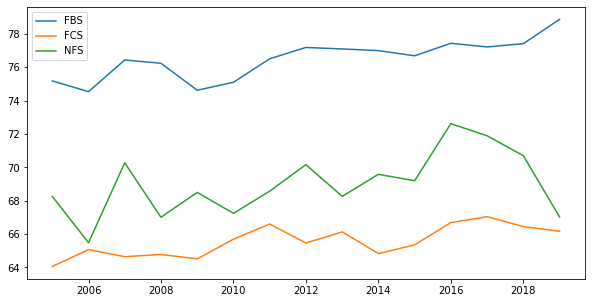

In [63]:
# Looking at weighted retention rate (target).
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Weighted Retention Rate'].max() - fbs_trends['Weighted Retention Rate'].min())
print('FCS:',fcs_trends['Weighted Retention Rate'].max() - fcs_trends['Weighted Retention Rate'].min())
print('NFS:',nfs_trends['Weighted Retention Rate'].max() - nfs_trends['Weighted Retention Rate'].min())
plt.plot(fbs_trends['Weighted Retention Rate'], label='FBS')
plt.plot(fcs_trends['Weighted Retention Rate'], label='FCS')
plt.plot(nfs_trends['Weighted Retention Rate'], label='NFS')
plt.legend();

FBS: 7528.75
FCS: 8496.545
NFS: 13473.13


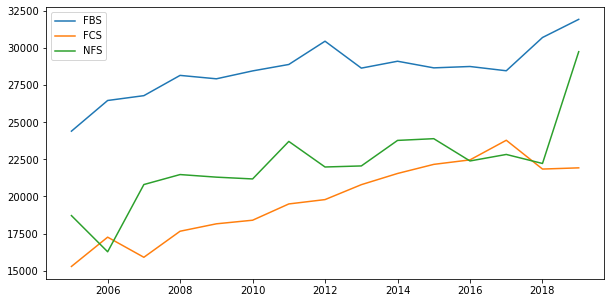

In [64]:
# Looking at academic spending per student
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Academic Spending per FTE Student'].max() - fbs_trends['Academic Spending per FTE Student'].min())
print('FCS:',fcs_trends['Academic Spending per FTE Student'].max() - fcs_trends['Academic Spending per FTE Student'].min())
print('NFS:',nfs_trends['Academic Spending per FTE Student'].max() - nfs_trends['Academic Spending per FTE Student'].min())
plt.plot(fbs_trends['Academic Spending per FTE Student'], label='FBS')
plt.plot(fcs_trends['Academic Spending per FTE Student'], label='FCS')
plt.plot(nfs_trends['Academic Spending per FTE Student'], label='NFS')
plt.legend();

FBS: 49112.59999999999
FCS: 19645.685000000005
NFS: 23009.184999999998


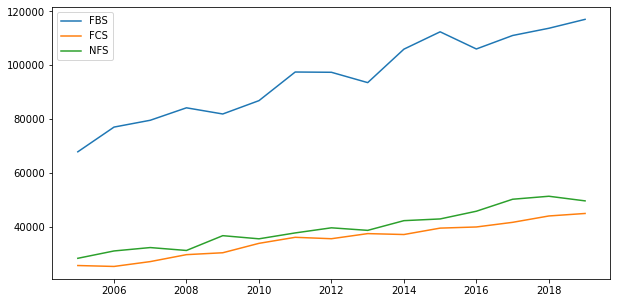

In [65]:
# Looking at athletic spending per student athlete
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Athletic Spending per Student Athlete'].max() - fbs_trends['Athletic Spending per Student Athlete'].min())
print('FCS:',fcs_trends['Athletic Spending per Student Athlete'].max() - fcs_trends['Athletic Spending per Student Athlete'].min())
print('NFS:',nfs_trends['Athletic Spending per Student Athlete'].max() - nfs_trends['Athletic Spending per Student Athlete'].min())
plt.plot(fbs_trends['Athletic Spending per Student Athlete'], label='FBS')
plt.plot(fcs_trends['Athletic Spending per Student Athlete'], label='FCS')
plt.plot(nfs_trends['Athletic Spending per Student Athlete'], label='NFS')
plt.legend();

FBS: 323506123.0
FCS: 71775169.41
NFS: 110993128.5


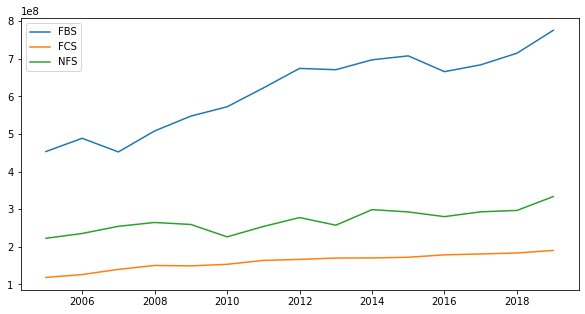

In [66]:
# Looking at total academic spending
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Total Academic Spending (University-Wide)'].max() - fbs_trends['Total Academic Spending (University-Wide)'].min())
print('FCS:',fcs_trends['Total Academic Spending (University-Wide)'].max() - fcs_trends['Total Academic Spending (University-Wide)'].min())
print('NFS:',nfs_trends['Total Academic Spending (University-Wide)'].max() - nfs_trends['Total Academic Spending (University-Wide)'].min())
plt.plot(fbs_trends['Total Academic Spending (University-Wide)'], label='FBS')
plt.plot(fcs_trends['Total Academic Spending (University-Wide)'], label='FCS')
plt.plot(nfs_trends['Total Academic Spending (University-Wide)'], label='NFS')
plt.legend();

FBS: 26218008.5
FCS: 8381785.5
NFS: 8736721.5


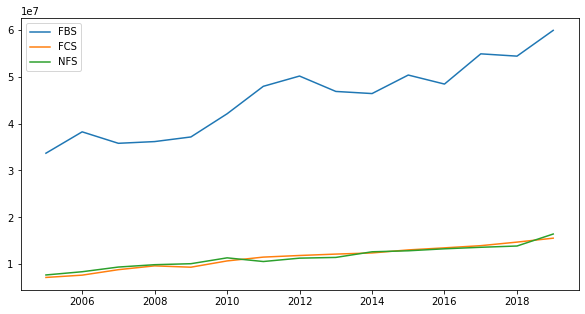

In [67]:
# Looking at total athletic spending
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Grand Total Expenses'].max() - fbs_trends['Grand Total Expenses'].min())
print('FCS:',fcs_trends['Grand Total Expenses'].max() - fcs_trends['Grand Total Expenses'].min())
print('NFS:',nfs_trends['Grand Total Expenses'].max() - nfs_trends['Grand Total Expenses'].min())
plt.plot(fbs_trends['Grand Total Expenses'], label='FBS')
plt.plot(fcs_trends['Grand Total Expenses'], label='FCS')
plt.plot(nfs_trends['Grand Total Expenses'], label='NFS')
plt.legend();

FBS: 22845074.5
FCS: 7963772.0
NFS: 8520954.5


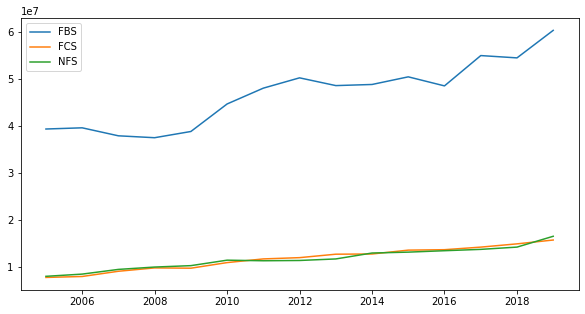

In [68]:
# Looking at total athletic revenues
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Grand Total Revenue'].max() - fbs_trends['Grand Total Revenue'].min())
print('FCS:',fcs_trends['Grand Total Revenue'].max() - fcs_trends['Grand Total Revenue'].min())
print('NFS:',nfs_trends['Grand Total Revenue'].max() - nfs_trends['Grand Total Revenue'].min())
plt.plot(fbs_trends['Grand Total Revenue'], label='FBS')
plt.plot(fcs_trends['Grand Total Revenue'], label='FCS')
plt.plot(nfs_trends['Grand Total Revenue'], label='NFS')
plt.legend();

FBS: 11239404.0
FCS: 2466097.5


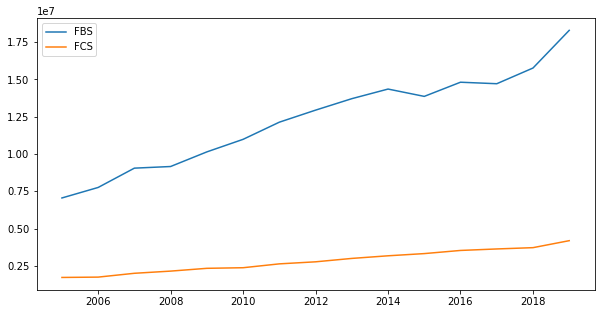

In [69]:
# Looking at total football spending (No NFS because they don't have football)
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Total Football Spending'].max() - fbs_trends['Total Football Spending'].min())
print('FCS:',fcs_trends['Total Football Spending'].max() - fcs_trends['Total Football Spending'].min())
plt.plot(fbs_trends['Total Football Spending'], label='FBS')
plt.plot(fcs_trends['Total Football Spending'], label='FCS')
plt.legend();

FBS: 3508416.0
FCS: 566081.5


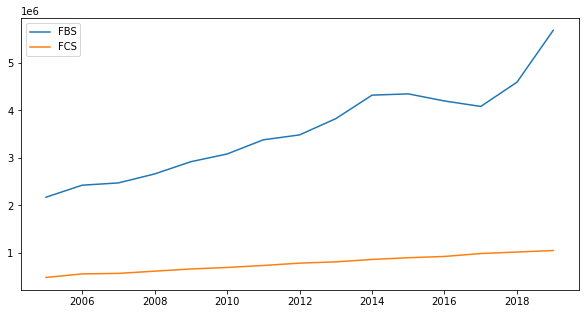

In [70]:
# Looking at total football spending (No NFS because they don't have football)
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Total Football Coaching Salaries'].max() - fbs_trends['Total Football Coaching Salaries'].min())
print('FCS:',fcs_trends['Total Football Coaching Salaries'].max() - fcs_trends['Total Football Coaching Salaries'].min())
plt.plot(fbs_trends['Total Football Coaching Salaries'], label='FBS')
plt.plot(fcs_trends['Total Football Coaching Salaries'], label='FCS')
plt.legend();

FBS: 1957729.5
FCS: 1308993.5
NFS: 1846748.0


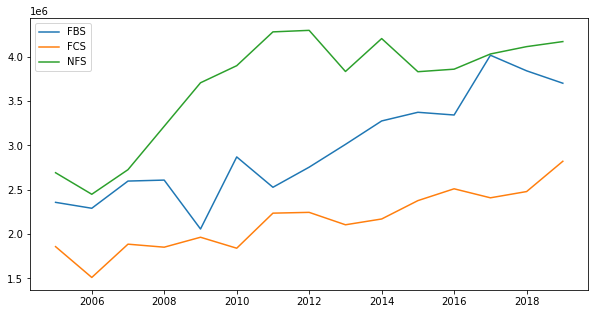

In [71]:
# Looking at student fees
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Student Fees'].max() - fbs_trends['Student Fees'].min())
print('FCS:',fcs_trends['Student Fees'].max() - fcs_trends['Student Fees'].min())
print('NFS:',nfs_trends['Student Fees'].max() - nfs_trends['Student Fees'].min())
plt.plot(fbs_trends['Student Fees'], label='FBS')
plt.plot(fcs_trends['Student Fees'], label='FCS')
plt.plot(nfs_trends['Student Fees'], label='NFS')
plt.legend();

FBS: 1.1346305136858579
FCS: 0.44523993785140314
NFS: 0.5551458322549636


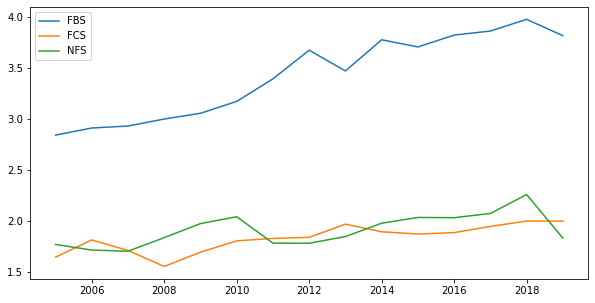

In [72]:
# Looking at ratio of athletic vs. academic spending
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - fbs_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('FCS:',fcs_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - fcs_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
print('NFS:',nfs_trends['Ratio of Athletic Spending vs. Academic Spending'].max() - nfs_trends['Ratio of Athletic Spending vs. Academic Spending'].min())
plt.plot(fbs_trends['Ratio of Athletic Spending vs. Academic Spending'], label='FBS')
plt.plot(fcs_trends['Ratio of Athletic Spending vs. Academic Spending'], label='FCS')
plt.plot(nfs_trends['Ratio of Athletic Spending vs. Academic Spending'], label='NFS')
plt.legend();

FBS: 3.0
FCS: 4.5
NFS: 4.0


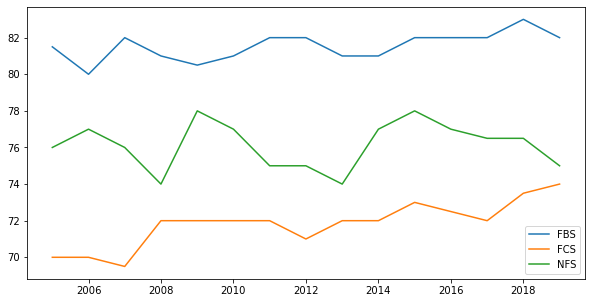

In [73]:
# Looking at full-time retention
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Full-time Retention Rate'].max() - fbs_trends['Full-time Retention Rate'].min())
print('FCS:',fcs_trends['Full-time Retention Rate'].max() - fcs_trends['Full-time Retention Rate'].min())
print('NFS:',nfs_trends['Full-time Retention Rate'].max() - nfs_trends['Full-time Retention Rate'].min())
plt.plot(fbs_trends['Full-time Retention Rate'], label='FBS')
plt.plot(fcs_trends['Full-time Retention Rate'], label='FCS')
plt.plot(nfs_trends['Full-time Retention Rate'], label='NFS')
plt.legend();

FBS: 8.5
FCS: 9.0
NFS: 14.0


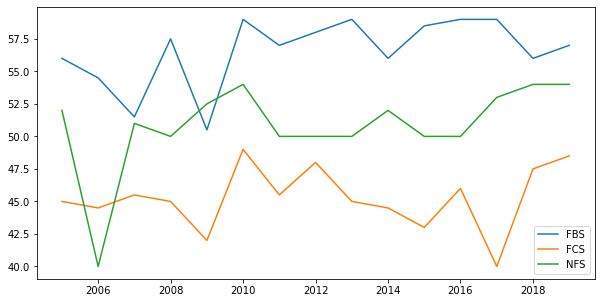

In [74]:
# Looking at part-time retention
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Part-time Retention Rate'].max() - fbs_trends['Part-time Retention Rate'].min())
print('FCS:',fcs_trends['Part-time Retention Rate'].max() - fcs_trends['Part-time Retention Rate'].min())
print('NFS:',nfs_trends['Part-time Retention Rate'].max() - nfs_trends['Part-time Retention Rate'].min())
plt.plot(fbs_trends['Part-time Retention Rate'], label='FBS')
plt.plot(fcs_trends['Part-time Retention Rate'], label='FCS')
plt.plot(nfs_trends['Part-time Retention Rate'], label='NFS')
plt.legend();

FBS: 20159.0
FCS: 14948.5
NFS: 17659.0


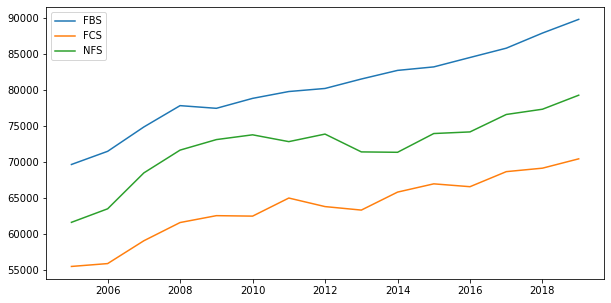

In [75]:
# Looking at part-time retention
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Average Faculty Salary'].max() - fbs_trends['Average Faculty Salary'].min())
print('FCS:',fcs_trends['Average Faculty Salary'].max() - fcs_trends['Average Faculty Salary'].min())
print('NFS:',nfs_trends['Average Faculty Salary'].max() - nfs_trends['Average Faculty Salary'].min())
plt.plot(fbs_trends['Average Faculty Salary'], label='FBS')
plt.plot(fcs_trends['Average Faculty Salary'], label='FCS')
plt.plot(nfs_trends['Average Faculty Salary'], label='NFS')
plt.legend();

FBS: 4716475.5
FCS: 4640594.5
NFS: 3596466.5


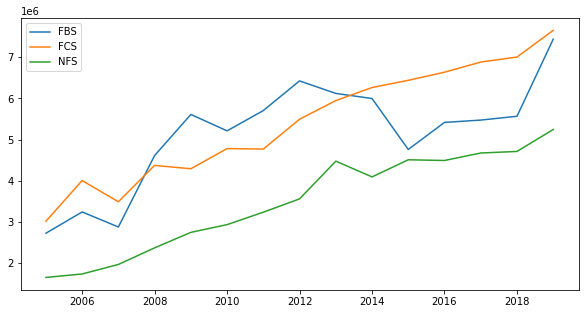

In [76]:
# Looking at institutional/government support
plt.subplots(figsize=(10,5))
print('FBS:',fbs_trends['Institutional/Government Support'].max() - fbs_trends['Institutional/Government Support'].min())
print('FCS:',fcs_trends['Institutional/Government Support'].max() - fcs_trends['Institutional/Government Support'].min())
print('NFS:',nfs_trends['Institutional/Government Support'].max() - nfs_trends['Institutional/Government Support'].min())
plt.plot(fbs_trends['Institutional/Government Support'], label='FBS')
plt.plot(fcs_trends['Institutional/Government Support'], label='FCS')
plt.plot(nfs_trends['Institutional/Government Support'], label='NFS')
plt.legend();

# Modeling

[Based on NCES data](https://nces.ed.gov/programs/coe/indicator/ctr) (used in IPEDS variables), the average retention rate is 81% for all institutions including all acceptance rates. Thus, I will use this as the dividing point for creating a binned variable.

In [77]:
# Creating binned target variable based on median for logistic regression
# df_binned['WRR_Binned'] = np.where(df_binned['Weighted_Retention_Rate']>=df_binned['Weighted_Retention_Rate'].median(), 1.0, 0.0)
df['WRR_Binned'] = np.where(df['Weighted Retention Rate']>81.0, 1.0, 0.0)

In [78]:
# Class imbalance in favor of schools that have less than average retention rates.
df['WRR_Binned'].value_counts(normalize=True)

0.0    0.780664
1.0    0.219336
Name: WRR_Binned, dtype: float64

In [84]:
# Create the X (features) and y (target)
# Also dropping columns used in feature engineering.
X = df.drop(columns=['Weighted Retention Rate', 'Full-time Retention Rate', 'Part-time Retention Rate', 'No. Full-Time Students Retained', 
                 'No. Part-Time Students Retained', 'Total Enrollment', 'Full-time Enrollment',
                 'Part-time Enrollment', 'Total Student Athletes', 'UNITID', 'Institution Name'])
y = df['WRR_Binned']

# split into 75% train, 15% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

In [ ]:
cat_cols = ['NCAA Subdivision', 'FBS Conference', 'Survey Year']

In [85]:
# categorical pipeline
cat_pipe = Pipeline([('ohe', OneHotEncoder())])

# numeric pipeline
num_pipe = Pipeline([('min_max', MinMaxScaler())])

# proportional numeric pipeline
prop_pipe = Pipeline([('div100', FunctionTransformer(lambda x: x/100))])

# preprocessing pipeline, allow the untransformed columns to 'passthrough'
preprocessor = ColumnTransformer(transformers=[('categorical', cat_pipe, cat_cols),
                                               ('numerical', num_pipe, num_cols),
                                               ('proportional', prop_pipe, prop_cols)],
                                 remainder='passthrough')

,Survey Year,Grand Total Revenue,Grand Total Expenses,NCAA Subdivision,FBS Conference,Excess Transfers Back,Other Expenses,Medical,Competition Guarantees (Expenses),Recruiting,...,Total Academic Spending (University-Wide),Total Football Spending,Total Football Coaching Salaries,Athletics Related Debt,"Annual Debt Service, Leases and Rental Fees on Athletic Facilities",Average Faculty Salary,Academic Spending per FTE Student,Athletic Spending per Student Athlete,Ratio of Athletic Spending vs. Academic Spending,WRR_Binned
0,2005-01-01,6955072,6764089,Football Championship Subdivision,N/A,0.0,128579.0,50000.0,10000.0,28178.0,...,105893529.0,1449620.0,418314.0,9000000.0,887926.0,51089,20328.96,24071.49,1.184098,0.0
166,2006-01-01,5221982,5221982,Football Championship Subdivision,N/A,0.0,562826.0,349608.0,37343.0,20484.0,...,109997605.0,1697310.0,624108.0,9361302.0,1140700.0,50908,21644.55,18784.11,0.867845,0.0
332,2007-01-01,6945839,6945839,Football Championship Subdivision,N/A,0.0,179990.0,333250.0,39000.0,34325.0,...,114831523.0,1760048.0,748500.0,9178120.0,659559.0,53544,22874.81,24371.36,1.065423,0.0
498,2008-01-01,6774498,6774498,Football Championship Subdivision,N/A,0.0,290440.0,212069.0,28200.0,61730.0,...,118162605.0,2175301.0,778500.0,9178120.0,659559.0,56522,24756.46,24108.53,0.973828,0.0
664,2009-01-01,6533933,5926809,Football Championship Subdivision,N/A,0.0,514363.0,226421.0,43500.0,42619.0,...,109214914.0,2092581.0,778500.0,8448000.0,1139645.0,60575,25222.84,24798.36,0.983171,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,2015-01-01,14928633,14928633,Football Championship Subdivision,N/A,0.0,1467048.0,135000.0,270500.0,316514.0,...,167483816.0,4169693.0,1349378.0,4869343.0,338177.0,72207,17798.49,39598.50,2.224824,0.0
1991,2016-01-01,15410657,15410657,Football Championship Subdivision,N/A,0.0,1233793.0,157431.0,184000.0,348444.0,...,165196688.0,3949953.0,1198488.0,4788115.0,338236.0,71982,17826.34,38526.64,2.161220,0.0
2157,2017-01-01,15876225,15876225,Football Championship Subdivision,N/A,0.0,1349715.0,75813.0,196000.0,356380.0,...,174854836.0,4023675.0,1273020.0,4269030.0,402410.0,73535,18411.59,39297.59,2.134394,0.0
2323,2018-01-01,16206122,16206122,Football Championship Subdivision,N/A,0.0,1300023.0,99135.0,228700.0,382963.0,...,172957393.0,4097973.0,1231410.0,4423609.0,385733.0,72465,18084.21,38132.05,2.108583,0.0
